## **15-02 바다나우 어텐션(Bahdanau Attention)**

앞서 어텐션 메커니즘의 목적과 어텐션 메커니즘의 일종인 닷 프로덕트 어텐션(루옹 어텐션)의 전체적인 개요를 살펴보고, 마지막에 표를 통해 그 외에도 다양한 어텐션 메커니즘이 존재한다고 소개하였습니다. 이번에는 닷 프로덕트 어텐션보다는 조금 더 복잡하게 설계된 바다나우 어텐션 메커니즘을 이해해봅시다.

---
### **1. 바다나우 어텐션 함수(Bahdanau Attention Function)**

어텐션 메커니즘을 함수 Attention()으로 정의하였을 때, 바다나우 어텐션 함수의 입, 출력은 다음과 같의 정의할 수 있습니다.  
  
$\mathbf{Attention(Q, K, V) = Attention Value}$

```python
    t = 어텐션 메커니즘이 수행되는 디코더 셀의 현재 시점을 의미.

    Q = Query : t-1 시점의 디코더 셀에서의 은닉 상태
    K = Keys : 모든 시점의 인코더 셀의 은닉 상태들
    V = Values : 모든 시점의 인코더 셀의 은닉 상태들
```


여기서는 어텐션 함수의 Query가 디코더 셀의 t 시점의 은닉 상태가 아니라 t-1 시점의 은닉 상태임을 주목합시다.

---
### **2. 바다나우 어텐션 (Bahdanau Attention)**

바다나우 어텐션의 연산 순서를 이해해봅시다.

#### **1) 어텐션 스코어(Attention Score)를 구한다.**

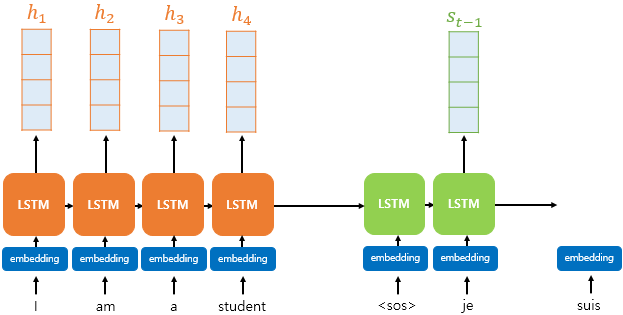

인코더의 시점(time step)을 각각 1, 2, ... N이라고 하였을 때 인코더의 은닉 상태(hidden state)를 각각 $h_1$, $h_2$, ... $h_N$라고 합시다. 디코더의 현재 시점(time step) t에서의 디코더의 은닉 상태(hidden state)를 $s_t$라고 합시다. 또한 여기서는 인코더의 은닉 상태와 디코더의 은닉 상태의 차원이 같다고 가정합니다. 위의 그림의 경우에는 인코더의 은닉 상태와 디코더의 은닉 상태가 동일하게 차원이 4입니다.

앞서 루옹 어텐션에서는 Query로 디코더의 t 시점의 은닉 상태 $s_{t-1}$를 사용한 것과는 달리 이번에는 t-1 시점의 은닉 상태 를 사용합니다. 바다나우 어텐션의 어텐션 스코어 함수. 즉, $s_{t-1}$과 인코더의 i번째 은닉 상태의 어텐션 스코어 계산 방법은 아래와 같습니다.

### $$score(s_{t-1}, h_i) = W_a^T tanh(W_bs_{t-1} + W_c h_i)$$




단, $W_a, W_b, W_c$는 학습 가능한 가중치 행렬입니다. s_{t-1}와 $h_1, h_2, h_3, h_4$의 어텐션 스코어를 각각 구해야하므로 병렬 연산을 위해 $h_1, h_2, h_3, h_4$를 하나의 행렬 $H$로 두겠습니다. 수식은 다음과 같이 변경됩니다.

### $$score(s_{t-1}, H) = W_a^T tanh(W_bs_{t-1} + W_c H)$$  

그림을 통해 이해해봅시다. 우선 $W_bs_{t-1}$와 $W_c H$를 각각 구하면 다음과 같습니다.

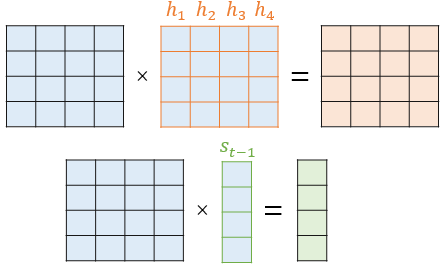

이들을 더한 후, 하이퍼볼릭탄젠트 함수를 지나도록 합니다.

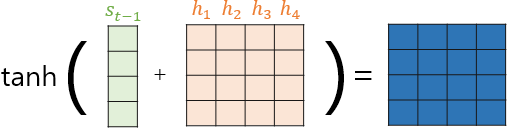

지금까지 진행된 연산의 수식은 다음과 같습니다.
#### $tanh(W_b s_{t-1} + W_c H)$



이제 $W_a^T$와 곱하여 $s_{t-1}$와 $h_1, h_2, h_3, h_4$의 유사도가 기록된 어텐션 스코어 벡터 를 얻습니다.



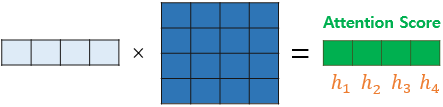
#### $e^t = W_a^T tanh(W_b s_{t-1} + W_c H)$

#### **2) 소프트맥스(softmax) 함수를 통해 어텐션 분포(Attention Distribution)를 구한다.**  
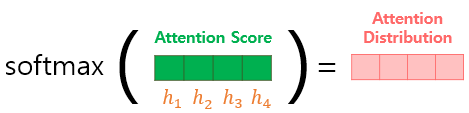


$e^t$에 소프트맥스 함수를 적용하여, 모든 값을 합하면 1이 되는 확률 분포를 얻어냅니다. 이를 어텐션 분포(Attention Distribution)라고 하며, 각각의 값은 어텐션 가중치(Attention Weight)라고 합니다.

#### **3) 각 인코더의 어텐션 가중치와 은닉 상태를 가중합하여 어텐션 값(Attention Value)을 구한다.**

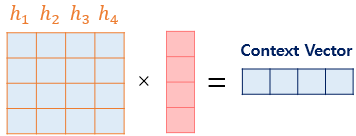

지금까지 준비해온 정보들을 하나로 합치는 단계입니다. 어텐션의 최종 결과값을 얻기 위해서 각 인코더의 은닉 상태와 어텐션 가중치값들을 곱하고, 최종적으로 모두 더합니다. 요약하면 가중합(Weighted Sum)을 한다고 말할 수도 있겠습니다. 이 벡터는 인코더의 문맥을 포함하고 있다고하여, **컨텍스트 벡터(context vector)** 라고 부릅니다.

#### **4) 컨텍스트 벡터로부터 $s_t$를 구합니다.**
기존의 LSTM이  $s_t$를 구할 때를 아래 그림을 통해 상기해봅시다. 기존의 LSTM은 이전 시점의 셀로부터 전달받은 은닉 상태  $s_{t-1}$와 현재 시점의 입력  $x_t$를 가지고 연산하였습니다. 아래의 LSTM은 seq2seq의 디코더이며 현재 시점의 입력 $x_t$는 임베딩된 단어 벡터입니다.

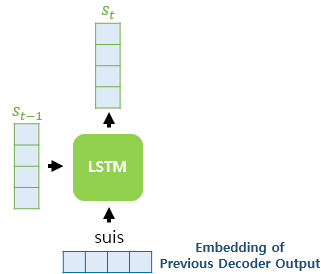

그렇다면 어텐션 메커니즘에서는 어떨까요? 아래의 그림은 바다나우 어텐션 메커니즘에서는 컨텍스트 벡터와 현재 시점의 입력인 단어의 임베딩 벡터를 연결(concatenate)하고, 현재 시점의 새로운 입력으로 사용하는 모습을 보여줍니다. 그리고 이전 시점의 셀로부터 전달받은 은닉 상태 $s_{t-1}$와 현재 시점의 새로운 입력으로부터 $s_t$를 구합니다. 기존의 LSTM이 임베딩된 단어 벡터를 입력으로 하는 것에서 컨텍스트 벡터와 임베딩된 단어 벡터를 연결(concatenate)하여 입력으로 사용하는 것이 달라졌습니다.

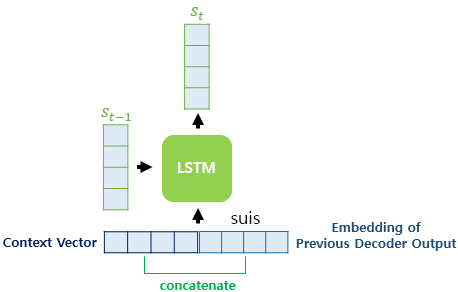

이후에는 어텐션 메커니즘을 사용하지 않는 경우와 동일합니다. $s_t$는 출력층으로 전달되어 현재 시점의 예측값을 구하게 됩니다.